# Neurons example, pt. 2: large datasets

In [1]:
import numpyro
from bayes_window import models, fake_spikes_explore, BayesWindow, BayesConditions, BayesRegression
from bayes_window.generative_models import generate_fake_spikes
import numpy as np
from importlib import reload
import altair as alt
alt.data_transformers.disable_max_rows()

try:
    alt.renderers.enable('altair_saver', fmts=['png'])
except Exception:
    pass

In [2]:

df, df_monster, index_cols, firing_rates = generate_fake_spikes(n_trials=20,
                                                                n_neurons=6,
                                                                n_mice=3,
                                                                dur=5,
                                                               mouse_response_slope=40,
                                                               overall_stim_response_strength=5)


## Two-step

## Packaged version 1
Separate levels

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  14 out of  18 | elapsed:  1.3min remaining:   22.2s
[Parallel(n_jobs=12)]: Done  18 out of  18 | elapsed:  1.4min finished


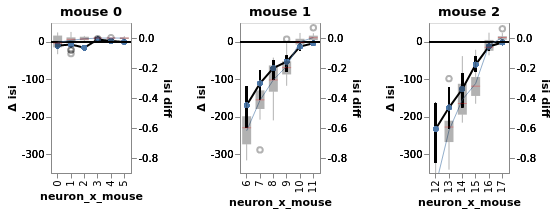

In [3]:
bw = BayesRegression(df=df_monster, y='isi',treatment='stim', condition=['neuron_x_mouse'],
                          group='mouse', detail='i_trial')
bw=bw.fit_twostep_by_group(dist_y_step_one='gamma', dist_y='student')

bw.chart

## Packaged version 2
No grouping in first step

In [5]:
bw = BayesRegression(df=df_monster, y='isi',treatment='stim', condition=['neuron_x_mouse'], group='mouse', detail='i_trial')
bw=bw.fit_twostep(dist_y_step_one='gamma', dist_y='student')

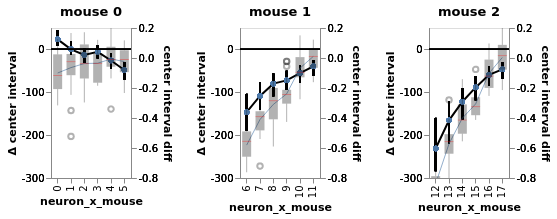

In [6]:
bw.chart

## Step by step

### 1. Firing rate

In [7]:
bw1 = BayesConditions(df=df_monster, y='isi',treatment='stim', condition=['neuron_x_mouse','i_trial'], group='mouse')
bw1.fit(dist_y='gamma');
# bw.plot_model_quality()

### 2. Regression

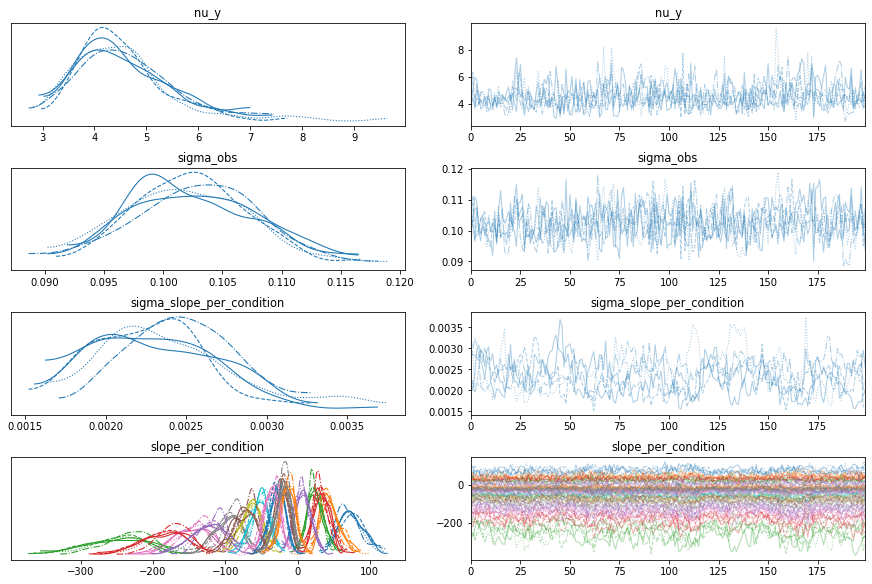

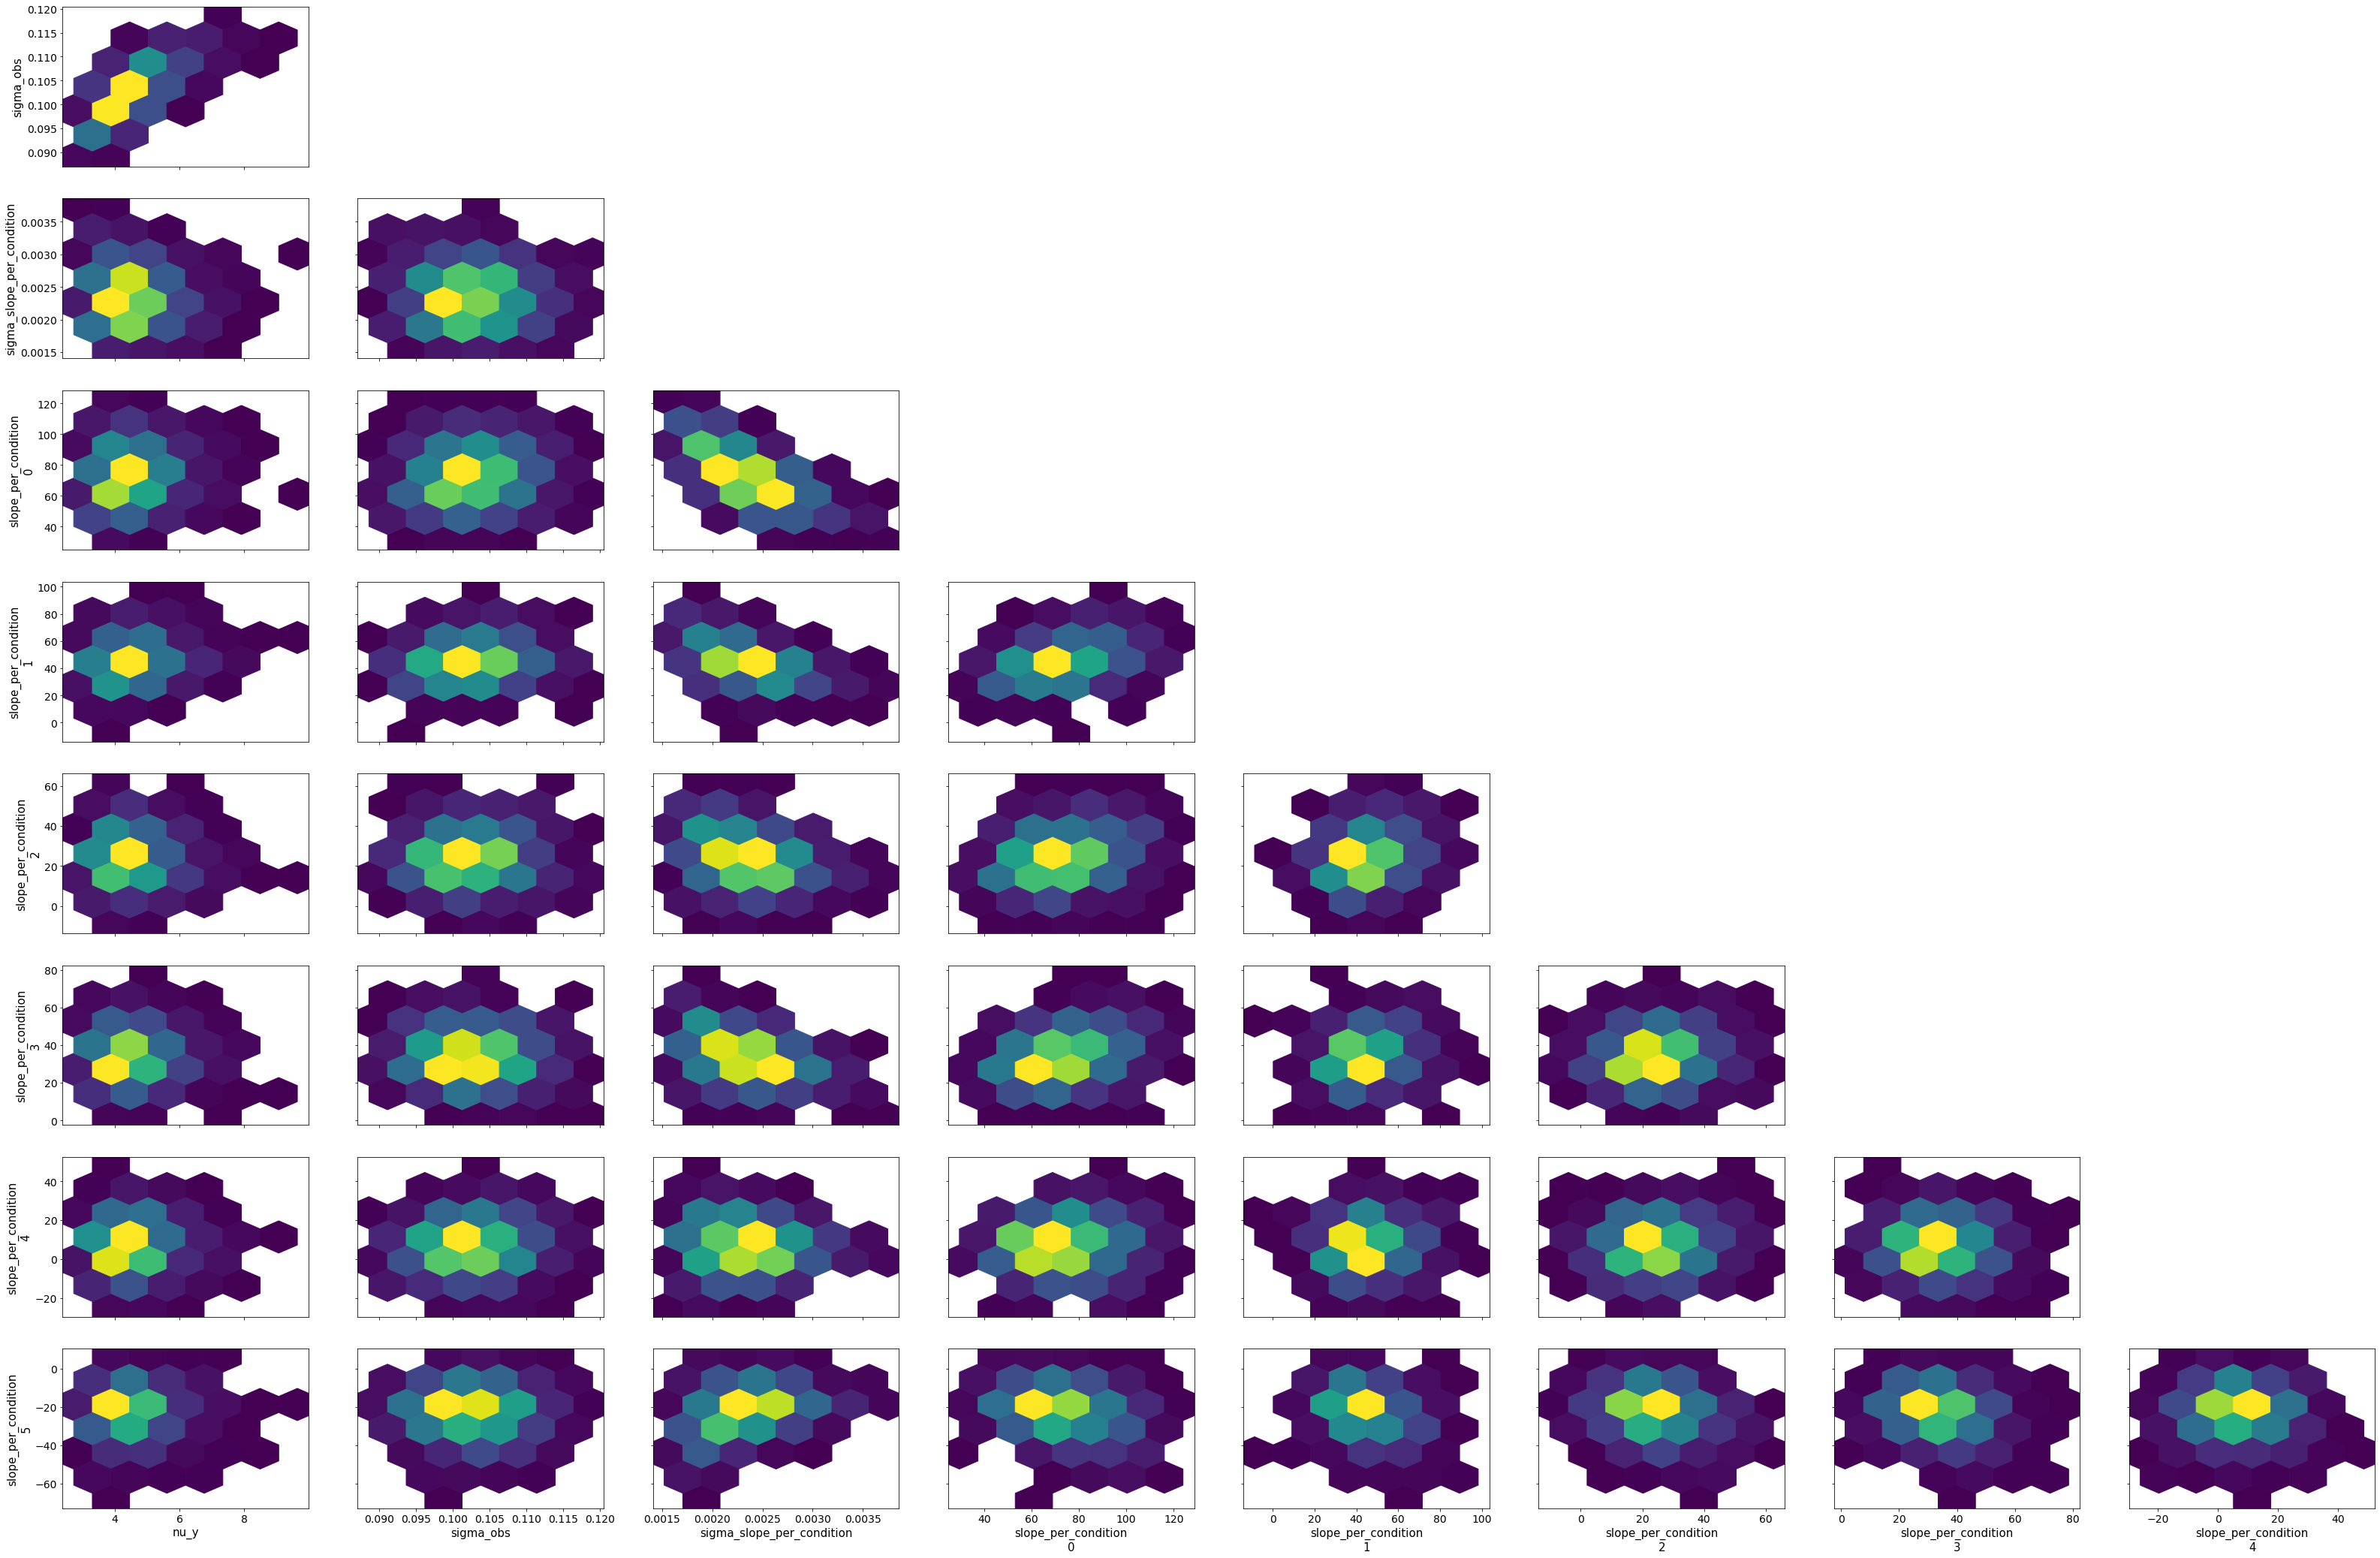

In [8]:
bw2 = BayesRegression(df=bw1.posterior['mu_per_condition'],
                 y='center interval', treatment='stim', condition=['neuron_x_mouse'], group='mouse')
bw2.fit(model=models.model_hierarchical,
               do_make_change='subtract',
               dist_y='student',
               robust_slopes=False,
               add_group_intercept=False,
               add_group_slope=False,
               fold_change_index_cols=('stim', 'mouse', 'neuron_x_mouse'))

bw2.plot_model_quality()

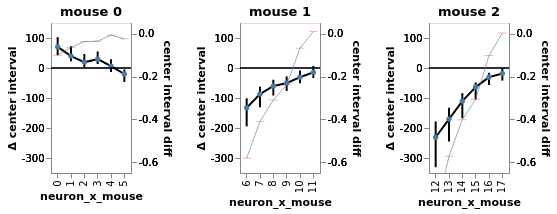

In [9]:
bw2.chart


## Each neuron separately via SVI
### 1. Firing rate

In [10]:
from tqdm import tqdm

gb='neuron_x_mouse'
step1_res=[]
for i, df_m_n in tqdm(df_monster.groupby(gb)):
    bw1 = BayesConditions(df_m_n, y='isi',treatment='stim', condition=['i_trial'], group='mouse'
                     ).fit(dist_y='gamma',
#                                       fit_fn=fitting.fit_svi
                                     )
    posterior=bw1.posterior['mu_per_condition'].copy()
    posterior[gb] = i
    step1_res.append(posterior)

  0%|          | 0/18 [00:00<?, ?it/s]

  6%|▌         | 1/18 [00:28<07:58, 28.13s/it]

 11%|█         | 2/18 [00:54<07:14, 27.16s/it]

 17%|█▋        | 3/18 [01:23<07:00, 28.00s/it]

 22%|██▏       | 4/18 [01:56<07:01, 30.12s/it]

 28%|██▊       | 5/18 [02:28<06:37, 30.61s/it]

 33%|███▎      | 6/18 [03:05<06:34, 32.83s/it]

 39%|███▉      | 7/18 [03:32<05:41, 31.02s/it]

 44%|████▍     | 8/18 [03:57<04:49, 28.95s/it]

 50%|█████     | 9/18 [04:22<04:08, 27.65s/it]

 56%|█████▌    | 10/18 [04:45<03:30, 26.35s/it]

 61%|██████    | 11/18 [05:13<03:07, 26.82s/it]

 67%|██████▋   | 12/18 [05:46<02:52, 28.77s/it]

 72%|███████▏  | 13/18 [06:20<02:31, 30.27s/it]

 78%|███████▊  | 14/18 [06:48<01:58, 29.68s/it]

 83%|████████▎ | 15/18 [07:16<01:27, 29.22s/it]

 89%|████████▉ | 16/18 [07:42<00:56, 28.13s/it]

 94%|█████████▍| 17/18 [08:08<00:27, 27.36s/it]

100%|██████████| 18/18 [08:43<00:00, 29.07s/it]


### 2. Regression
TODO add sigma to step 2 inputs


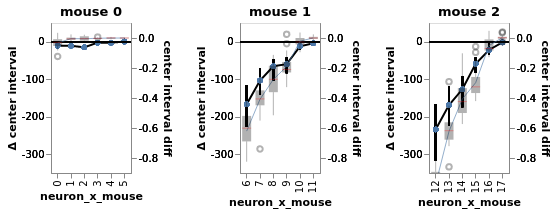

In [11]:
import pandas as pd
bw2 = BayesRegression(pd.concat(step1_res),
                 y='center interval', treatment='stim', condition=['neuron_x_mouse'], group='mouse',
                  detail='i_trial')
bw2.fit(model=models.model_hierarchical,
        do_make_change='subtract',
        dist_y='student',
        robust_slopes=False,
        add_group_intercept=False,
        add_group_slope=False)
bw2.chart

## NUTS 1-step GLM

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

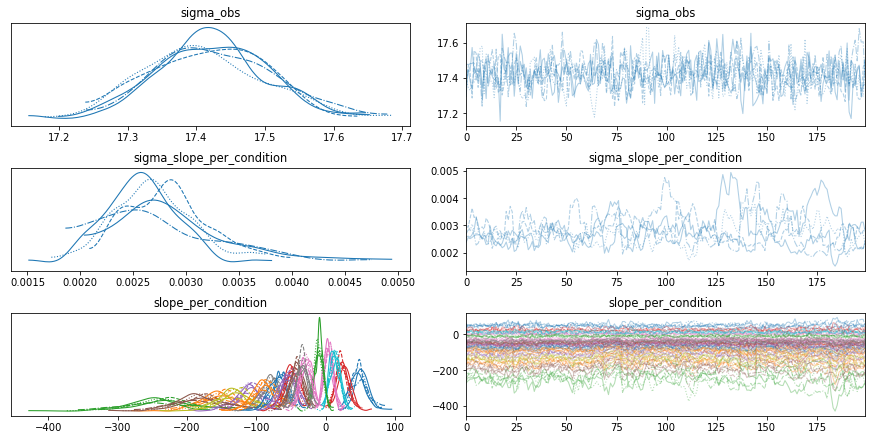

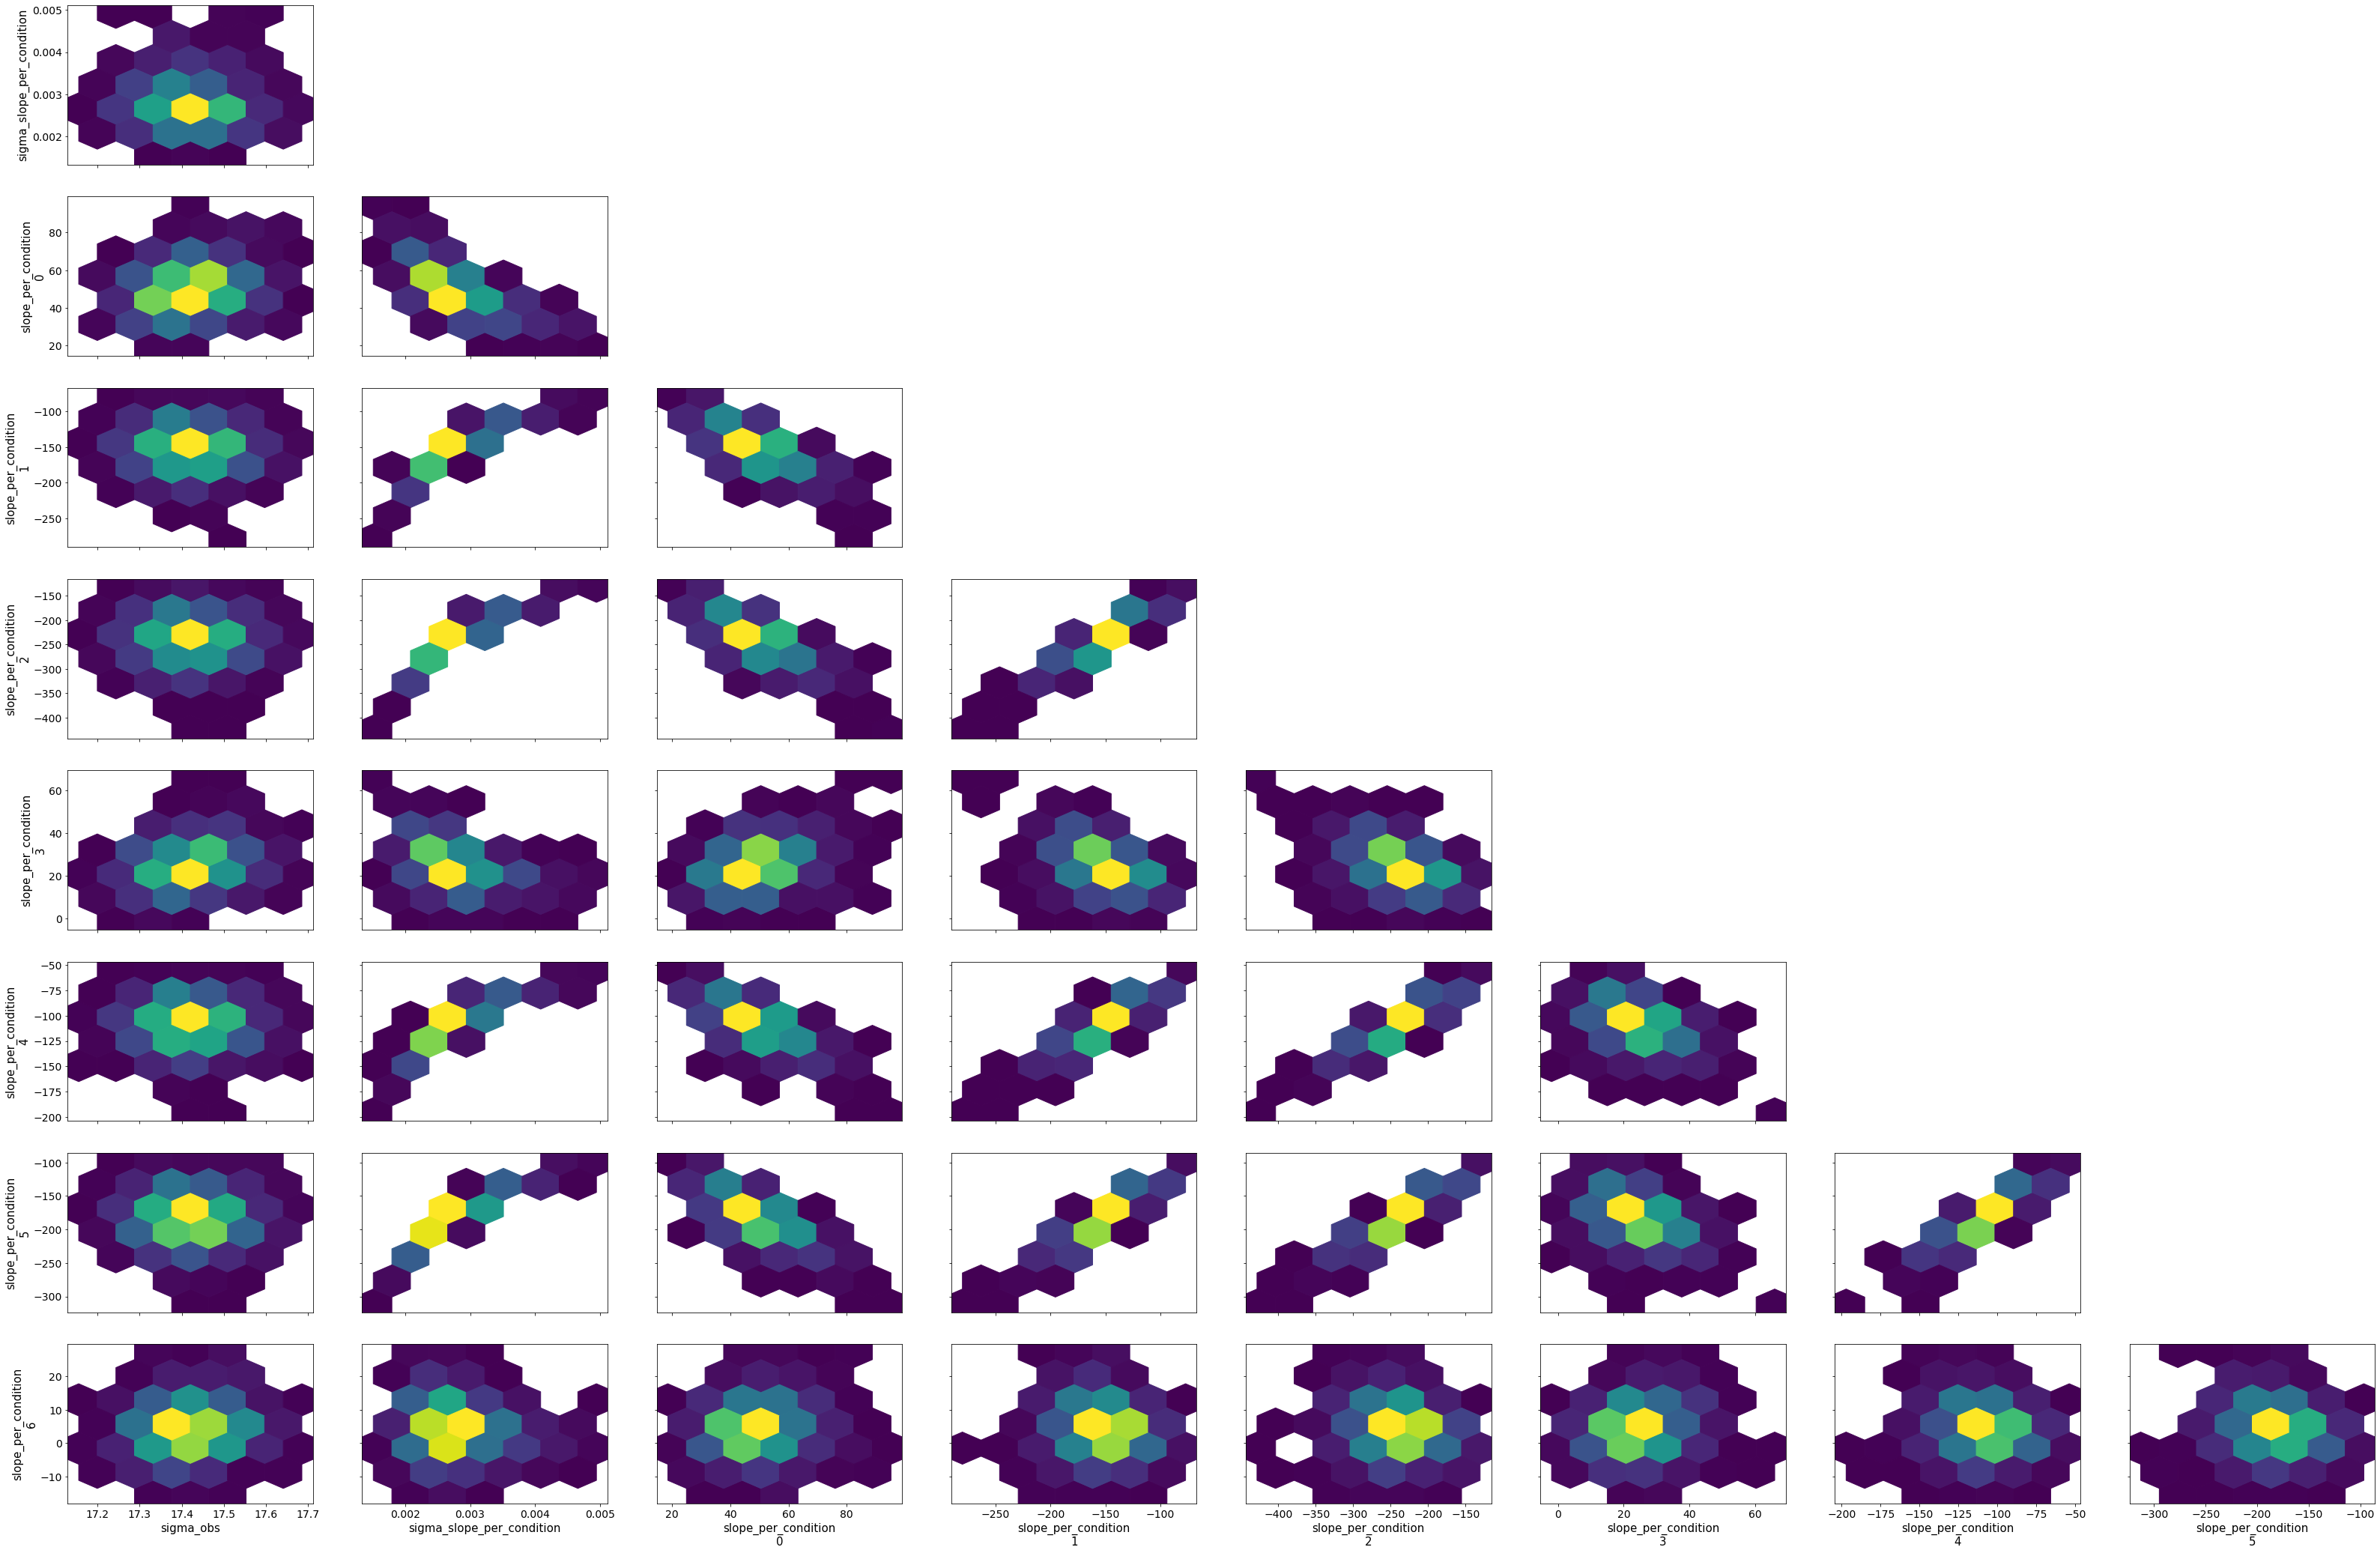

In [12]:
# Gamma GLM
bw = BayesRegression(df_monster, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit(model=models.model_hierarchical,
       progress_bar=True,
       do_make_change='subtract',
       dist_y='gamma',
       robust_slopes=False,
       add_group_intercept=False,
       add_group_slope=False,
       fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

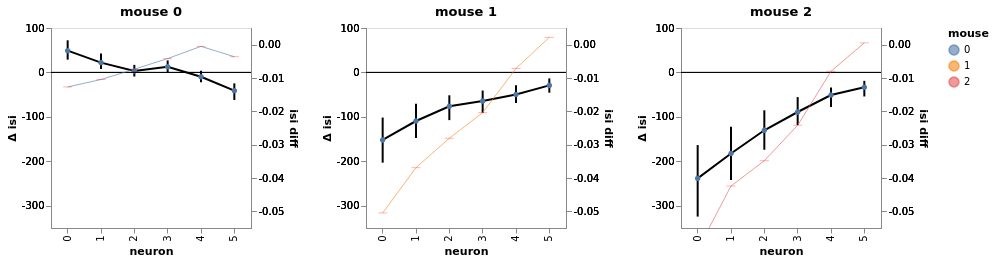

In [13]:
import altair as alt
alt.data_transformers.disable_max_rows()
bw.plot(x='neuron', color='mouse', independent_axes=True, finalize=True)


bw.facet(column='mouse',width=200,height=200).display()

## NUTS student

In [ ]:
bw = BayesRegression(df=df_monster, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit(model=models.model_hierarchical,
              progress_bar=True,
              do_make_change='subtract',
              dist_y='student',
              robust_slopes=False,
              add_group_intercept=False,
              add_group_slope=False,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot_model_quality()

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

In [ ]:

bw.plot(x='neuron', color='mouse', independent_axes=True, finalize=True)


bw.facet(column='mouse',width=200,height=200).display()

In [ ]:

bw = BayesRegression(df_monster, y='isi', treatment='stim', condition='neuron_x_mouse', group='mouse')
bw.fit(model=models.model_hierarchical, do_make_change='subtract',
              progress_bar=True,
              dist_y='student',
              use_gpu=True,
              num_chains=1,
              num_warmup=500,
              add_group_slope=True, add_group_intercept=False,
              fold_change_index_cols=('stim', 'mouse', 'neuron','neuron_x_mouse'))

bw.plot(x='neuron', color='mouse', independent_axes=True, finalize=True)
bw.facet(column='mouse',width=200,height=200).display()

#bw.explore_models(use_gpu=True)

## NUTS Lognormal

In [ ]:
bw = BayesRegression(df=df_monster, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit(model=models.model_hierarchical, do_make_change='subtract',
              progress_bar=True,
              use_gpu=True, num_chains=1, n_draws=1500, num_warmup=1500,
              dist_y='lognormal',
              add_group_slope=True, add_group_intercept=True,
              fold_change_index_cols=('stim', 'mouse', 'neuron'))

bw.plot(x='neuron', color='mouse', independent_axes=True, finalize=True)


bw.facet(column='mouse',width=200,height=200).display()

In [ ]:
bw.explore_models(add_group_slope=True)

## BarkerMH

In [ ]:
%%time
from bayes_window import fitting

from importlib import reload
reload(fitting)

bw = BayesRegression(df=df_monster, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit(model=models.model_hierarchical, do_make_change='subtract',
              sampler=numpyro.infer.BarkerMH,
#               progress_bar=True,
              use_gpu=False, num_chains=1, n_draws=5000, num_warmup=3000,
              dist_y='student',
              add_group_slope=True, add_group_intercept=True,
              fold_change_index_cols=('stim', 'mouse', 'neuron'),
              fit_method=fitting.fit_numpyro,
             )

bw.plot(x='neuron', color='mouse', independent_axes=True, finalize=True)


bw.facet(column='mouse',width=200,height=200).display()

## Fit using SVI

In [ ]:
%%time
from bayes_window import fitting
bw = BayesRegression(df=df_monster, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit(model=models.model_hierarchical, do_make_change='subtract',
              n_draws=5000,
              dist_y='gamma',
              add_group_slope=True, add_group_intercept=False,
              fold_change_index_cols=('stim', 'mouse', 'neuron'),
              fit_method=fitting.fit_svi,
             )

bw.plot(x='neuron', color='mouse', independent_axes=True, finalize=True)


bw.facet(column='mouse',width=200,height=200).display()

In [ ]:
%%time
from bayes_window import fitting
import numpyro
from importlib import reload
reload(fitting)
bw = BayesRegression(df=df_monster, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit(model=models.model_hierarchical, do_make_change='subtract',

            autoguide=numpyro.infer.autoguide.AutoLaplaceApproximation,
            optim=numpyro.optim.Adam(step_size=0.0005),
            loss=numpyro.infer.Trace_ELBO(),
              dist_y='lognormal',
              add_group_slope=True, add_group_intercept=True,
              fold_change_index_cols=('stim', 'mouse', 'neuron'),
              fit_method=fitting.fit_svi,

              n_draws=int(1e5),
              num_warmup=int(1e5),
             )

bw.plot(x='neuron', color='mouse', independent_axes=True, finalize=True)


bw.facet(column='mouse',width=200,height=200).display()

In [ ]:
%%time
from bayes_window import fitting
import numpyro
#numpyro.enable_validation(False)
bw = BayesRegression(df=df_monster, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit(model=models.model_hierarchical, do_make_change='subtract',
              #use_gpu=True,
            autoguide=numpyro.infer.autoguide.AutoLaplaceApproximation,
            optim=numpyro.optim.Adam(1),
            loss=numpyro.infer.Trace_ELBO(),
              dist_y='lognormal',
              add_group_slope=True, add_group_intercept=False,
              fold_change_index_cols=('stim', 'mouse', 'neuron'),
              fit_method=fitting.fit_svi,
              #progress_bar=False,
              n_draws=int(1e5),
              num_warmup=int(1e5),
             )

bw.plot(x='neuron', color='mouse', independent_axes=True, finalize=True)


bw.facet(column='mouse',width=200,height=200).display()

Pretty model

In [ ]:
reload(models)
bw = BayesRegression(df=df, y='isi', treatment='stim', condition=['neuron', 'mouse'], group='mouse')
bw.fit(model=models.reparam_model(models.model_hierarchical_for_render), do_make_change='subtract',
              progress_bar=True,
              use_gpu=False, num_chains=1, n_draws=1500, num_warmup=1500,
              dist_y='normal',
              add_group_slope=True, add_group_intercept=True,
              fold_change_index_cols=('stim', 'mouse', 'neuron'))

bw.plot(x='neuron', color='mouse', independent_axes=True, finalize=True)


bw.facet(column='mouse',width=200,height=200).display()

In [ ]:
#!pip install git+https://github.com/pyro-ppl/numpyro.git
from numpyro.contrib.render import render_model
reload(models)
render_model(models.model_hierarchical_for_render, model_args=(1, 1, 1, 1,
                                                    'gamma', True,
                                                    True),
             render_distributions=True)

In [ ]:
#!pip install git+https://github.com/pyro-ppl/numpyro.git
from numpyro.contrib.render import render_model
reload(models)
render_model(models.model_hierarchical_for_render, model_args=(1, 1, 1, 1,
                                                    'gamma', True,
                                                    False),
             render_distributions=True)

In [ ]:
#!pip install git+https://github.com/pyro-ppl/numpyro.git
from numpyro.contrib.render import render_model
reload(models)
render_model(models.model_hier_stim_one_codition, model_args=(1, 1, 1,
                                                    'gamma',
                                                    ),
             render_distributions=True)
